#  **Deep Neural Networks for Image Classification**

*   Multilayer Perceptron (MLP)
   *  Load (train) CIFAR10 dataset (32x32 RGB images; 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’);
   *  Compute mean and standard deviation for data normalization;
   *  Load normalized (train and test) CIFAR10 dataset;
   *  Split train set into train and validation set;
   *  Create iterators;
   *  Build the model;
   *  Test the model;
   *  Finetuning of the hyper-parameters.

	• Use the GPU to speed up the training time of you models (Runtime -> Change runtime type -> Hardware accelerator -> GPU).  

In [1]:
# Pytorch functions
import torch
# Neural network layers
import torch.nn as nn
import torch.nn.functional as F
# Optimizer
import torch.optim as optim
# Handling dataset
import torch.utils.data as data
# Torchvision library
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import copy
import time
import os
import cv2
# For results
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
# Load CIFAR10 dataset
# Available datasets at https://pytorch.org/vision/stable/datasets.html
ROOT = './data'
train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True)

# You can also use the 'transform' argument to specify transformations to apply to the dataset
# e.g. 'train_data = torchvision.datasets.CIFAR10(root=ROOT, train=True, download=True, transform=...)'
# See the next steps for applying transformations to a dataset.


Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
print("-------  DATASET  INFO  --------")
print(train_data)
print()
print(train_data.data.shape)

-------  DATASET  INFO  --------
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train

(50000, 32, 32, 3)


In [5]:
# Each train/test example ia a tuple (image, label)
print("------  DATAPOINT  INFO  ---------")
img = train_data[0][0]
label = train_data[0][1]
print(img) # N_CHANNELS, HEIGHT, WIDTH
print(label)

------  DATAPOINT  INFO  ---------
<PIL.Image.Image image mode=RGB size=32x32 at 0x7F0F0CA7A890>
6


*  Data normalization

In [6]:
# Print min and max rgb values for an image
min_RGB_values = train_data.data[0].min(axis=(0,1))
print(f"Minimum RGB values : {min_RGB_values}")
max_RGB_values = train_data.data[0].max(axis=(0,1))
print(f"Maximum RGB values : {max_RGB_values}")

Minimum RGB values : [0 0 0]
Maximum RGB values : [255 253 235]


In [7]:
# Data normalization
# Mean and std should be divided by 255 (maximum pixel value)
# because, after the ToTensor() transformation (see next step), images are normalized
# between 0 and 1.

train_mean = train_data.data.mean(axis=(0,1,2)) / 255
train_std = train_data.data.std(axis=(0,1,2)) / 255

print("-----  TRAIN NORMALIZATION VALUES  -----")
print(f"Mean: {train_mean}")
print(f"Standard Deviation: {train_std}")

-----  TRAIN NORMALIZATION VALUES  -----
Mean: [0.49139968 0.48215841 0.44653091]
Standard Deviation: [0.24703223 0.24348513 0.26158784]


In [8]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(), # values are normalized between 0 and 1
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

test_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

In [9]:
# Load data with transformations
train_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=True,
                                        download=True,
                                        transform=train_transforms)

test_data = torchvision.datasets.CIFAR10(root=ROOT,
                                        train=False,
                                        download=True,
                                        transform=test_transforms)
print(train_data)
print(test_data)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.49139968 0.48215841 0.44653091], std=[0.24703223 0.24348513 0.26158784])
           )


In [10]:
# Each train/test example ia a tuple (image, label)
print("------  DATAPOINT  INFO  ---------")
img = train_data[0][0]
label = train_data[0][1]
print(f"Image size: {img.size()}") # N_CHANNELS, HEIGHT, WIDTH
print(f"Label: {label}")

------  DATAPOINT  INFO  ---------
Image size: torch.Size([3, 32, 32])
Label: 6


In [11]:
min_RGB_values = train_data[0][0].amin(dim=(1,2))
print(f"Minimum RGB values : {min_RGB_values}")
max_RGB_values = train_data[0][0].amax(dim=(1,2))
print(f"Maximum RGB values : {max_RGB_values}")

Minimum RGB values : tensor([-1.9892, -1.9802, -1.7070])
Maximum RGB values : tensor([2.0588, 2.0946, 1.8160])


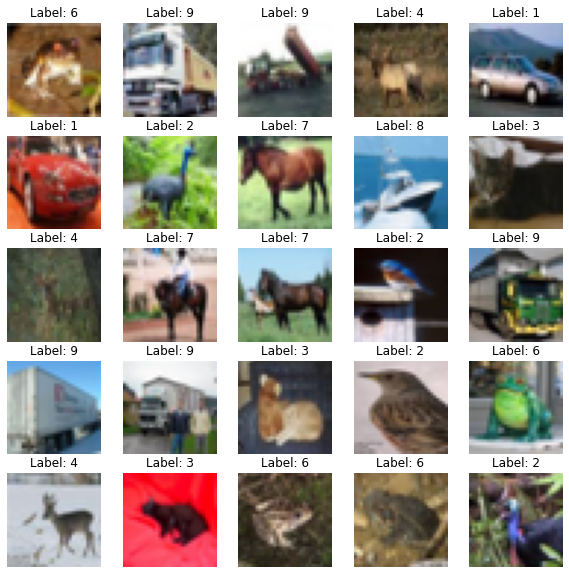

In [12]:
# Plot some training images
N_IMAGES = 25
plt.figure(figsize=(10, 10))
for i in range(N_IMAGES):
  img = train_data.data[i] # Unnormalized images
  label = train_data[i][1]
  plt.subplot(5,5,i+1), plt.imshow(img), plt.title(f"Label: {label}"), plt.axis('off')

In [13]:
# Split train data into train and validation sets
# (20% of training set will be used as validation set)
num_train_examples = int(len(train_data) * 0.8)
num_valid_examples = len(train_data) - num_train_examples

print(f"Number of training examples: {num_train_examples}")
print(f"Number of validation examples: {num_valid_examples}")

Number of training examples: 40000
Number of validation examples: 10000


In [14]:
# Create 'Subset' objects
train_data, valid_data = data.random_split(train_data, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_data)}")
print(f"Number validation examples: {len(valid_data)}")

Number training examples: 40000
Number validation examples: 10000


In [15]:
# Apply test transformations to the validation set
valid_data = copy.deepcopy(valid_data) # If we change train transformations, this won't affect the validation set
valid_data.dataset.transform = test_transforms

In [16]:
# Create iterators
BATCH_SIZE = 256

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                             batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data, 
                                            batch_size=BATCH_SIZE)

# Linear Layer 

A PyTorch layer can be defined as a class (using the 'nn' package) or as a function (using the 'functional' package). In the following, an example of using the 'nn' package.

In [ ]:
# List of pytorch layers available at https://pytorch.org/docs/stable/nn.html
x = torch.randn((20,20))
linear_layer = nn.Linear(400,10) # (in_features, out_features)
relu = nn.ReLU()
y = relu(linear_layer(x.view(20*20)))
print(y.shape)
print(y)

torch.Size([10])
tensor([0.2178, 0.0000, 0.0000, 0.0000, 0.0964, 0.0000, 0.7262, 0.0000, 0.0000,
        0.0431], grad_fn=<ReluBackward0>)


# **Model**

Let's create a simple MLP network with three layers.

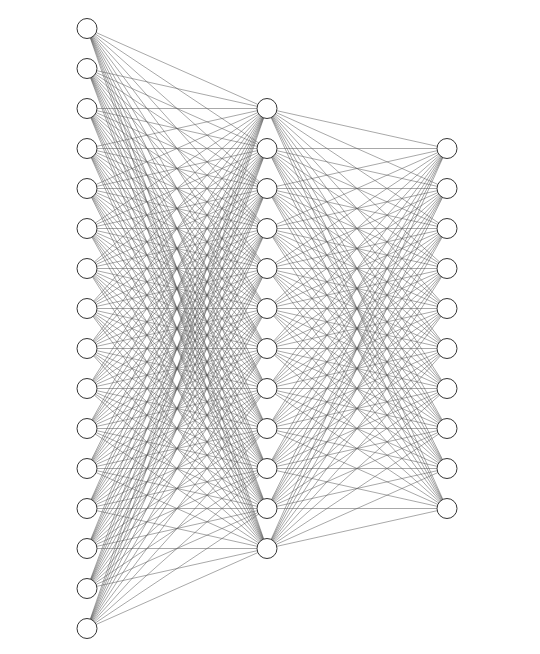

Input Layer: 32 * 32 * 3 = 3072 Units

Hidden Layer 1: 100 Units

Output Layer: 10 Units

In [30]:
# MLP architecture: [3072] -> [100] -> Sigmoid -> [10]

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()

    self.linear_layers = nn.Sequential(
        nn.Linear(input_dim, 100), 
        nn.Sigmoid(), # [ReLU, Tanh, Identity]
        nn.Linear(100, output_dim) 
    )

    
  def forward(self, x):
    batch_size = x.shape[0]
    # Flatten x
    x = x.view(batch_size, -1)
    y = self.linear_layers(x)
    return y

In [ ]:
# # Alternative way to define a NN
# class MLP(nn.Module):
#   def __init__(self, input_dim, output_dim):
#     super().__init__()

#     self.fc1 = nn.Linear(input_dim, 100)
#     self.fc2 = nn.Linear(100, output_dim)

#   def forward(self, x):
#     batch_size = x.shape[0]
#     # Flatten x
#     x = x.view(batch_size, -1)
#     x = self.fc1(x)
#     x = F.sigmoid(x)
#     x = self.fc2(x)
        
#     return x

In [17]:
INPUT_DIM = 32*32*3 # 32x32x3 images
OUTPUT_DIM = 10 # 10 classes

In [ ]:
# Inizialize the network
model = MLP(INPUT_DIM, OUTPUT_DIM)
print(model)

MLP(
  (linear_layers): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)


# **Ex.1**

Count the number of parameters in the previously defined model.

In [ ]:
# List of parameters
for name, param in model.named_parameters():
  print(f"{name}, {param.shape}")

linear_layers.0.weight, torch.Size([100, 3072])
linear_layers.0.bias, torch.Size([100])
linear_layers.2.weight, torch.Size([10, 100])
linear_layers.2.bias, torch.Size([10])


In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"The model has {count_parameters(model):,} trainable parameters.")

The model has 308,310 trainable parameters.


* Loss and Optimizer

In [18]:
# Loss
criterion = nn.CrossEntropyLoss() # Softmax + CrossEntropy

# Put model&criterion on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

In [ ]:
# Optim
optimizer = optim.SGD(model.parameters(), lr=5e-4)

model = model.to(device)

*  Training phase

In [19]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Train mode
  model.train()

  for (x,y) in iterator:
    x = x.to(device)
    y = y.to(device)
    # Set gradients to zero
    optimizer.zero_grad()
    
    # Make Predictions
    y_pred = model(x)

    # Compute loss
    loss = criterion(y_pred, y)
    
    # Compute accuracy
    acc = calculate_accuracy(y_pred, y)

    # Backprop
    loss.backward()

    # Apply optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

* Validation/Testing phase

In [20]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for (x,y) in iterator:

      x = x.to(device)
      y = y.to(device)
      
      # Make Predictions
      y_pred = model(x)

      # Compute loss
      loss = criterion(y_pred, y)
      
      # Compute accuracy
      acc = calculate_accuracy(y_pred, y)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [21]:
def calculate_accuracy(y_pred, y):
  '''
  Compute accuracy from ground-truth and predicted labels.
  
  Input
  ------
  y_pred: torch.Tensor [BATCH_SIZE, N_LABELS]
  y: torch.Tensor [BATCH_SIZE]

  Output
  ------
  acc: float
    Accuracy
  '''
  y_prob = F.softmax(y_pred, dim = -1)
  y_pred = y_pred.argmax(dim=1, keepdim = True)
  correct = y_pred.eq(y.view_as(y_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc

*  Model training

In [22]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Initialize validation loss
  best_valid_loss = float('inf')

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
    # Save best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()
    
    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100:.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

In [ ]:
N_EPOCHS = 20
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS, 
                                                                    model, 
                                                                    train_iterator, 
                                                                    valid_iterator, 
                                                                    optimizer, 
                                                                    criterion, 
                                                                    device,
                                                                    'mlp.pt')


Epoch: 1/20 -- Epoch Time: 6.56 s
---------------------------------
Train -- Loss: 2.353, Acc: 10.00%
Val -- Loss: 2.325, Acc: 10.10%

Epoch: 2/20 -- Epoch Time: 6.53 s
---------------------------------
Train -- Loss: 2.301, Acc: 11.06%
Val -- Loss: 2.282, Acc: 11.92%

Epoch: 3/20 -- Epoch Time: 6.54 s
---------------------------------
Train -- Loss: 2.266, Acc: 13.01%
Val -- Loss: 2.250, Acc: 13.75%

Epoch: 4/20 -- Epoch Time: 6.53 s
---------------------------------
Train -- Loss: 2.239, Acc: 14.79%
Val -- Loss: 2.227, Acc: 15.69%

Epoch: 5/20 -- Epoch Time: 6.53 s
---------------------------------
Train -- Loss: 2.218, Acc: 17.13%
Val -- Loss: 2.208, Acc: 18.20%

Epoch: 6/20 -- Epoch Time: 6.53 s
---------------------------------
Train -- Loss: 2.201, Acc: 19.95%
Val -- Loss: 2.192, Acc: 21.05%

Epoch: 7/20 -- Epoch Time: 6.53 s
---------------------------------
Train -- Loss: 2.188, Acc: 22.71%
Val -- Loss: 2.179, Acc: 23.21%

Epoch: 8/20 -- Epoch Time: 6.53 s
--------------------

In [23]:
def plot_results(n_epochs, train_losses, train_accs, valid_losses, valid_accs):
  N_EPOCHS = n_epochs
  # Plot results
  plt.figure(figsize=(20, 6))
  _ = plt.subplot(1,2,1)
  plt.plot(np.arange(N_EPOCHS)+1, train_losses, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_losses, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Loss')

  _ = plt.subplot(1,2,2)
  plt.plot(np.arange(N_EPOCHS)+1, train_accs, linewidth=3)
  plt.plot(np.arange(N_EPOCHS)+1, valid_accs, linewidth=3)
  _ = plt.legend(['Train', 'Validation'])
  plt.grid('on'), plt.xlabel('Epoch'), plt.ylabel('Accuracy')

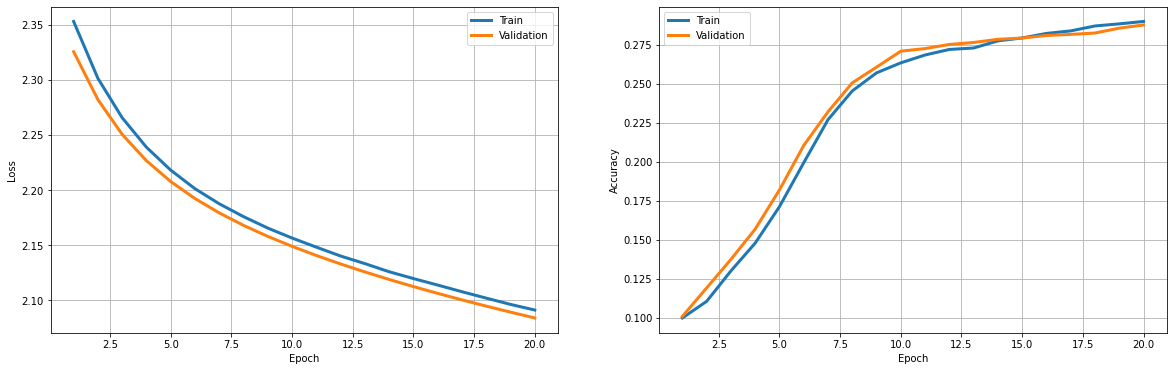

In [ ]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [24]:
def model_testing(model, test_iterator, criterion, device, model_name='best_model.pt'):
  # Test model
  model.load_state_dict(torch.load(model_name))
  test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
  print(f"Test -- Loss: {test_loss:.3f}, Acc: {test_acc * 100:.2f} %")

In [ ]:
model_testing(model, test_iterator, criterion, device, 'mlp.pt')

Test -- Loss: 2.085, Acc: 29.20 %


*  Confusion matrix and classification report

In [25]:
def predict(model, iterator, device):
  
  # Evaluation mode
  model.eval()
  
  labels = []
  pred = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred = model(x)

      # Get label with highest score
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim=True)

      labels.append(y.cpu())
      pred.append(top_pred.cpu())

  labels = torch.cat(labels, dim=0)
  pred = torch.cat(pred, dim=0)
  
  return labels, pred


In [26]:
def print_report(model, test_iterator, device):
  labels, pred = predict(model, test_iterator, device)
  print(confusion_matrix(labels, pred))
  print("\n")
  print(classification_report(labels, pred))

In [ ]:
print_report(model, test_iterator, device)

[[460  18   8  10  16  23  47  23 293 102]
 [ 91 104   2  35  34  55 168  27 206 278]
 [215  22  40  34  71  96 291  58  98  75]
 [134  17  19 100  46 200 233  68  65 118]
 [ 85  16  31  43 161  98 358  60  63  85]
 [102   9  11  79  42 302 199  66 115  75]
 [ 78  14  11  44  30  90 543  69  26  95]
 [ 99  10   7  73  82 106 147 149  85 242]
 [122  18   3   9  15  62  29   6 561 175]
 [ 86  37   1  15  19  18  85  26 188 525]]


              precision    recall  f1-score   support

           0       0.31      0.46      0.37      1000
           1       0.39      0.10      0.16      1000
           2       0.30      0.04      0.07      1000
           3       0.23      0.10      0.14      1000
           4       0.31      0.16      0.21      1000
           5       0.29      0.30      0.29      1000
           6       0.26      0.54      0.35      1000
           7       0.27      0.15      0.19      1000
           8       0.33      0.56      0.42      1000
           9       0.30   

*  Plot the weights to check if a neuron has learned to look for specific patterns in the input.

In [27]:
def normalize_image(image):
  image = torch.clamp(image, min = image.min(), max = image.max())
  image = torch.add(image, -image.min()).div_(image.max() - image.min() + 1e-5)
  return image

Weights shape: torch.Size([100, 3072])


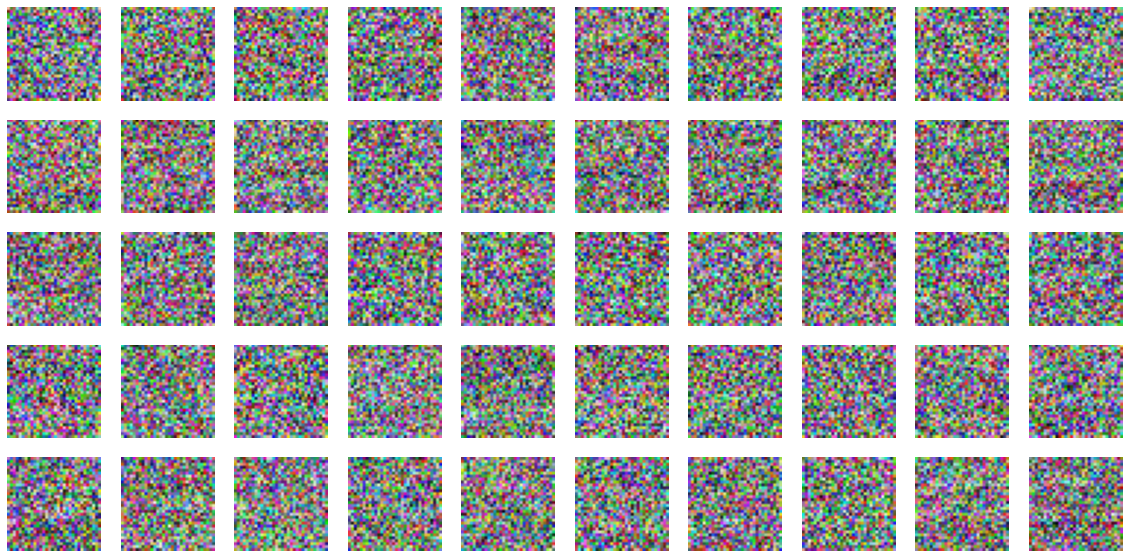

In [ ]:
# Plot weights
weights = model.linear_layers[0].weight.data
print(f"Weights shape: {weights.shape}")
plt.figure(figsize=(20, 10))
for i in range(50):
  plt.subplot(5, 10, i+1), plt.imshow(normalize_image(weights[i].view(32,32,3)).cpu().numpy())
  plt.axis('off')


# **Data augmentation**

* Pytorch transformations are available at https://pytorch.org/vision/stable/transforms.html.

In [28]:
# Compositions of transformations
train_transforms = torchvision.transforms.Compose([
                                                   torchvision.transforms.RandomRotation(60),
                                                   torchvision.transforms.RandomHorizontalFlip(p=0.7),
                                                   torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize(train_mean, train_std)
])

In [31]:
train_data.dataset.transform = train_transforms

train_iterator = torch.utils.data.DataLoader(train_data, 
                                             shuffle=True, 
                                             batch_size=BATCH_SIZE)

# Create new model
model = MLP(INPUT_DIM, OUTPUT_DIM)

optimizer = optim.SGD(model.parameters(), lr=5e-3) # New learning rate

model = model.to(device)

In [ ]:
N_EPOCHS = 20
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS, 
                                                                    model, 
                                                                    train_iterator, 
                                                                    valid_iterator, 
                                                                    optimizer, 
                                                                    criterion, 
                                                                    device,
                                                                    'mlp_data_aug.pt')


Epoch: 1/20 -- Epoch Time: 9.84 s
---------------------------------
Train -- Loss: 2.245, Acc: 18.43%
Val -- Loss: 2.184, Acc: 22.92%

Epoch: 2/20 -- Epoch Time: 9.86 s
---------------------------------
Train -- Loss: 2.164, Acc: 24.77%
Val -- Loss: 2.121, Acc: 25.59%

Epoch: 3/20 -- Epoch Time: 9.85 s
---------------------------------
Train -- Loss: 2.116, Acc: 26.24%
Val -- Loss: 2.078, Acc: 27.21%

Epoch: 4/20 -- Epoch Time: 9.84 s
---------------------------------
Train -- Loss: 2.082, Acc: 27.51%
Val -- Loss: 2.047, Acc: 27.71%

Epoch: 5/20 -- Epoch Time: 9.86 s
---------------------------------
Train -- Loss: 2.053, Acc: 28.05%
Val -- Loss: 2.022, Acc: 28.71%

Epoch: 6/20 -- Epoch Time: 9.88 s
---------------------------------
Train -- Loss: 2.031, Acc: 28.93%
Val -- Loss: 2.002, Acc: 29.12%

Epoch: 7/20 -- Epoch Time: 9.84 s
---------------------------------
Train -- Loss: 2.013, Acc: 29.25%
Val -- Loss: 1.988, Acc: 29.57%

Epoch: 8/20 -- Epoch Time: 9.83 s
--------------------

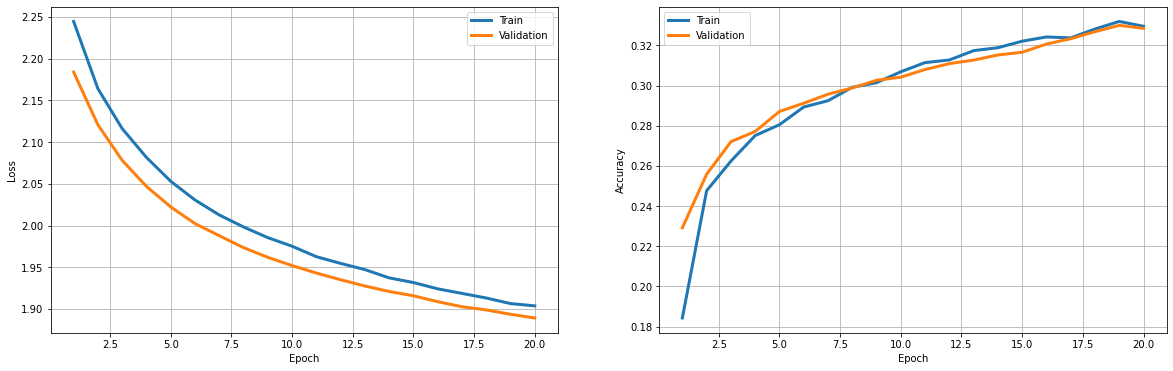

In [ ]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [ ]:
model_testing(model, test_iterator, criterion, device, 'mlp_data_aug.pt')

Test -- Loss: 1.890, Acc: 33.11 %


In [ ]:
print_report(model, test_iterator, device)

[[440  54  10   8   7   8  29  44 302  98]
 [ 51 331   6  17  17  28  78  25 199 248]
 [164  81  65  30 108  69 202 137  72  72]
 [ 64 106  23 111  55 185 136 114  68 138]
 [ 73  63  53  42 199  49 286 120  46  69]
 [ 56  80  25  72  57 266 148 117 103  76]
 [ 28  70  33  40  45  75 521  71  17 100]
 [ 61  72  22  34 104  62  92 305  66 182]
 [114  69   2  21   4  29   4  11 596 150]
 [ 48 120   6  10  13  12  52  23 220 496]]


              precision    recall  f1-score   support

           0       0.40      0.44      0.42      1000
           1       0.32      0.33      0.32      1000
           2       0.27      0.07      0.10      1000
           3       0.29      0.11      0.16      1000
           4       0.33      0.20      0.25      1000
           5       0.34      0.27      0.30      1000
           6       0.34      0.52      0.41      1000
           7       0.32      0.30      0.31      1000
           8       0.35      0.60      0.44      1000
           9       0.30   

# **Weights Initialization**

Weights initialization methods are available at https://pytorch.org/docs/stable/nn.init.html


In [ ]:
def weights_init(model):
    if isinstance(model, nn.Linear):
        nn.init.uniform_(model.weight.data, -0.02, 0.02) # [zeros_, normal_, xavier_uniform_, xavier_normal_]
        nn.init.constant_(model.bias, 0.01)

In [ ]:
model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.SGD(model.parameters(), lr=5e-3)
model = model.to(device)

In [ ]:
# Apply initialization
model.apply(weights_init)

MLP(
  (linear_layers): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [ ]:
# Weights Initialization + Data Augmentation
N_EPOCHS = 20
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS, 
                                                                    model, 
                                                                    train_iterator, 
                                                                    valid_iterator, 
                                                                    optimizer, 
                                                                    criterion, 
                                                                    device,
                                                                    'mlp_new_weights.pt')


Epoch: 1/20 -- Epoch Time: 10.07 s
---------------------------------
Train -- Loss: 2.297, Acc: 13.97%
Val -- Loss: 2.287, Acc: 20.06%

Epoch: 2/20 -- Epoch Time: 10.05 s
---------------------------------
Train -- Loss: 2.279, Acc: 20.45%
Val -- Loss: 2.263, Acc: 20.95%

Epoch: 3/20 -- Epoch Time: 10.05 s
---------------------------------
Train -- Loss: 2.253, Acc: 21.12%
Val -- Loss: 2.229, Acc: 21.46%

Epoch: 4/20 -- Epoch Time: 10.04 s
---------------------------------
Train -- Loss: 2.221, Acc: 21.58%
Val -- Loss: 2.192, Acc: 22.55%

Epoch: 5/20 -- Epoch Time: 10.04 s
---------------------------------
Train -- Loss: 2.187, Acc: 22.74%
Val -- Loss: 2.157, Acc: 22.79%

Epoch: 6/20 -- Epoch Time: 10.04 s
---------------------------------
Train -- Loss: 2.155, Acc: 23.42%
Val -- Loss: 2.126, Acc: 23.74%

Epoch: 7/20 -- Epoch Time: 10.05 s
---------------------------------
Train -- Loss: 2.128, Acc: 24.31%
Val -- Loss: 2.099, Acc: 24.41%

Epoch: 8/20 -- Epoch Time: 10.05 s
------------

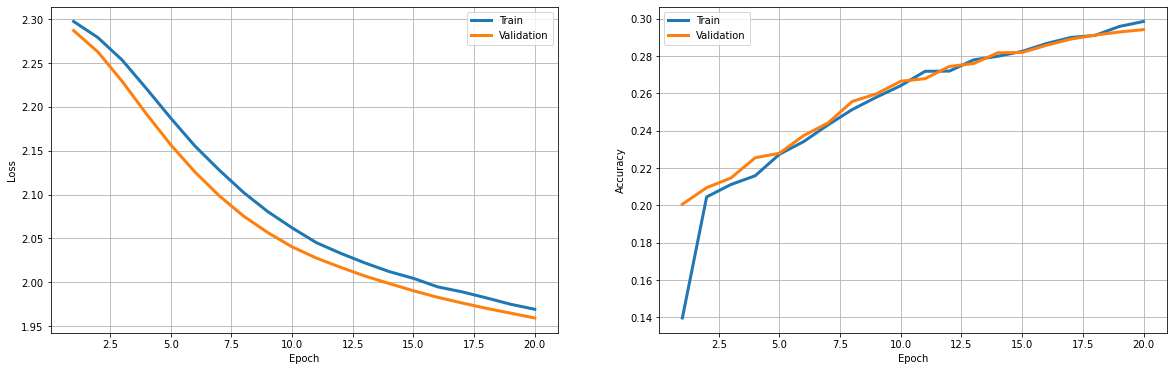

In [ ]:
plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)

In [ ]:
model_testing(model, test_iterator, criterion, device, 'mlp_new_weights.pt')

Test -- Loss: 1.961, Acc: 29.25 %


In [ ]:
print_report(model, test_iterator, device)

[[427  45   4   3   6  18  31  37 315 114]
 [ 43 197   4   7   4  45 110  26 221 343]
 [183  67  21   9  74  75 257 128  61 125]
 [ 80  71  14  23  37 200 219 106  57 193]
 [ 74  52  17  14 131  80 355 130  45 102]
 [ 80  65  16  17  43 269 198 111  90 111]
 [ 34  65  12   9  28  78 542  87  11 134]
 [ 76  50  14  12  90  96 139 207  62 254]
 [127  42   0   2   5  47   6  10 559 202]
 [ 43  63   3   1   5  16  71  23 216 559]]


              precision    recall  f1-score   support

           0       0.37      0.43      0.39      1000
           1       0.27      0.20      0.23      1000
           2       0.20      0.02      0.04      1000
           3       0.24      0.02      0.04      1000
           4       0.31      0.13      0.18      1000
           5       0.29      0.27      0.28      1000
           6       0.28      0.54      0.37      1000
           7       0.24      0.21      0.22      1000
           8       0.34      0.56      0.42      1000
           9       0.26   

Let's create a different architecture using dropout, Adam optimizer and a different linear layers' initialization.


Epoch: 1/20 -- Epoch Time: 12.81 s
---------------------------------
Train -- Loss: 2.025, Acc: 29.11%
Val -- Loss: 1.795, Acc: 36.08%

Epoch: 2/20 -- Epoch Time: 12.65 s
---------------------------------
Train -- Loss: 1.795, Acc: 35.90%
Val -- Loss: 1.741, Acc: 36.78%

Epoch: 3/20 -- Epoch Time: 12.77 s
---------------------------------
Train -- Loss: 1.733, Acc: 38.22%
Val -- Loss: 1.691, Acc: 39.42%

Epoch: 4/20 -- Epoch Time: 12.61 s
---------------------------------
Train -- Loss: 1.688, Acc: 39.86%
Val -- Loss: 1.669, Acc: 39.94%

Epoch: 5/20 -- Epoch Time: 12.78 s
---------------------------------
Train -- Loss: 1.661, Acc: 40.93%
Val -- Loss: 1.667, Acc: 40.37%

Epoch: 6/20 -- Epoch Time: 12.79 s
---------------------------------
Train -- Loss: 1.638, Acc: 41.58%
Val -- Loss: 1.617, Acc: 42.48%

Epoch: 7/20 -- Epoch Time: 12.66 s
---------------------------------
Train -- Loss: 1.611, Acc: 42.52%
Val -- Loss: 1.613, Acc: 42.03%

Epoch: 8/20 -- Epoch Time: 12.80 s
------------

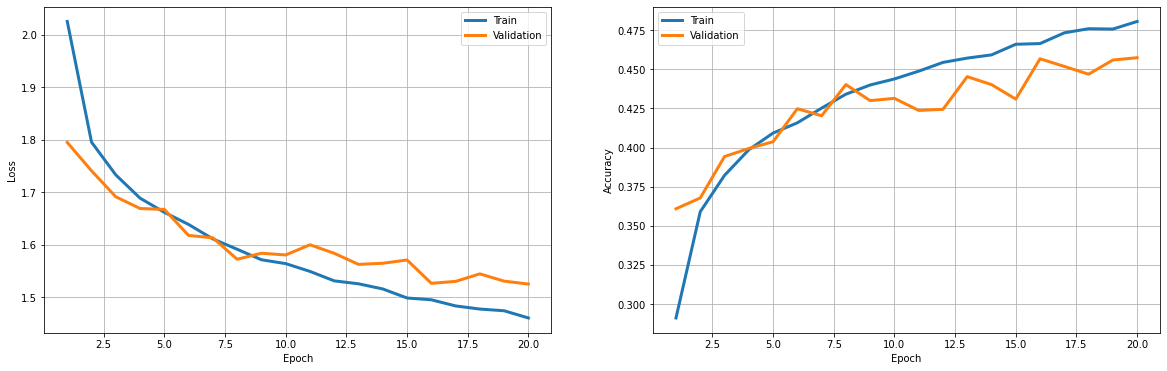

In [32]:
# Previous data augmentation is applied
# MLP architecture: [3072] -> [1500] -> ReLU -> Dropout(0.3) -> [750] -> ReLU -> Dropout(0.1) -> [300] ->
# -> ReLU -> Dropout(0.1) -> [10]

def weights_init(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight.data)
        nn.init.constant_(model.bias, 0.01)

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()

    self.linear_layers = nn.Sequential(
        nn.Linear(input_dim, 1500), 
        nn.ReLU(),
        nn.Dropout(0.3), 
        nn.Linear(1500, 750),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(750, 300),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(300, 10)
    )

    
  def forward(self, x):
    batch_size = x.shape[0]
    # Flatten x
    x = x.view(batch_size, -1)
    y = self.linear_layers(x)
    return y

model = MLP(INPUT_DIM, OUTPUT_DIM)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model = model.to(device)


# Apply initialization
model.apply(weights_init)

# Weights Initialization + Data Augmentation
N_EPOCHS = 20
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS, 
                                                                    model, 
                                                                    train_iterator, 
                                                                    valid_iterator, 
                                                                    optimizer, 
                                                                    criterion, 
                                                                    device,
                                                                    model_name='final_mlp.pt')

plot_results(N_EPOCHS, train_losses, train_accs, valid_losses, valid_accs)
model_testing(model, test_iterator, criterion, device, model_name='final_mlp.pt')
print_report(model, test_iterator, device)

# **Ex. 2**

Previous networks, implemented by the `MLP` class, are not optimal for this dataset. Design a new architecture and set the corresponding hyper-parameters in order to achieve better performance on the test set. Some parameters to focus on are listed below:

#### *Network's parameters*:

- Number of layers;
- Number of neurons per layer;
- Activation functions;
- Weights initialization;
- Dropout Rate.

#### *Training parameters*:
- Learning rate;
- Number of epochs;
- Optimizer.

#### *Data*:
- Data augmentation.